# Import Required Libraries
This cell imports essential libraries for data manipulation, model training, and evaluation.

In [2]:
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load Data
This cell pulls the latest data using DVC, constructs the data path, and loads the insurance dataset into a pandas DataFrame.

In [3]:
!dvc pull
notebook_dir = os.getcwd()
data_path = os.path.join(notebook_dir, "..", "data", "MachineLearningRating_v3.txt")

df = pd.read_csv(data_path, delimiter="|")

Everything is up to date.


C:\Users\Bisrat\AppData\Local\Temp\ipykernel_1932\825271066.py:5: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, delimiter="|")


# Drop Rows with Missing Target Values
This cell removes rows where the target variables (TotalClaims, CalculatedPremiumPerTerm) are missing to ensure clean training data.

In [4]:
# Drop rows where target variables are missing
df = df.dropna(subset=["TotalClaims", "CalculatedPremiumPerTerm"])

# Add Claim Occurrence Column
This cell adds a boolean column indicating whether a claim occurred for each policy.

In [5]:
# Add a boolean column for claims
df["ClaimOccurred"] = df["TotalClaims"] > 0

# Feature Engineering: Vehicle Age and Correlation
This cell creates a VehicleAge feature and examines its correlation with claims and premiums.

In [6]:
df["VehicleAge"] = 2015 - df["RegistrationYear"]

df[["VehicleAge", "TotalClaims", "CalculatedPremiumPerTerm"]].corr()


,VehicleAge,TotalClaims,CalculatedPremiumPerTerm
VehicleAge,1.000000,-0.005197,-0.065814
TotalClaims,-0.005197,1.000000,0.079787
CalculatedPremiumPerTerm,-0.065814,0.079787,1.000000


# Encode Categorical Variables
This cell selects categorical columns, applies one-hot encoding, and inspects the resulting DataFrame.

In [7]:
# Choose categorical variables
categorical_cols = ["Gender", "Province", "VehicleType", "make", "Model", "CoverType"]

# One-hot encode
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Inspect
df_encoded.head()


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,CoverType_Keys and Alarms,CoverType_Own Damage,CoverType_Passenger Liability,CoverType_Roadside Assistance,CoverType_Signage and Vehicle Wraps,CoverType_Standalone passenger liability,CoverType_Third Party,CoverType_Third Party Only,CoverType_Trailer,CoverType_Windscreen
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,False,False,False,False,False,False,False,False,False,True
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,False,False,False,False,False,False,False,False,False,True
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,False,False,False,False,False,False,False,False,False,True
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,False,True,False,False,False,False,False,False,False,False
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,False,True,False,False,False,False,False,False,False,False


# Save Cleaned Dataset
This cell saves the cleaned and encoded dataset for future use.

In [9]:
# Save the cleaned dataset
df_encoded.to_csv("../data/cleaned_encoded_data.csv", index=False)


# Prepare Data for Severity Modeling
This cell filters for rows with claims, defines features and target, and splits the data into training and test sets.

In [8]:
df_claims = df_encoded[df_encoded["ClaimOccurred"] == True]

# Define features and target
X = df_claims.drop(columns=["TotalClaims", "CalculatedPremiumPerTerm", "ClaimOccurred"])
y = df_claims["TotalClaims"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and Evaluate Random Forest Regressor
This cell trains a Random Forest model to predict claim severity and evaluates its performance.

In [9]:
# Drop non-numeric columns from features
X_train_num = X_train.select_dtypes(exclude=['object'])
X_test_num = X_test.select_dtypes(exclude=['object'])

model = RandomForestRegressor(random_state=42)
model.fit(X_train_num, y_train)

# Predict
y_pred = model.predict(X_test_num)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


RMSE: 38063.68
R²: 0.10


# Train and Evaluate Linear Regression Model
This cell imputes missing values, trains a linear regression model, and evaluates its performance.

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# Use SimpleImputer to fill NaN values with column means
imputer = SimpleImputer(strategy="mean")
X_train_num_filled = imputer.fit_transform(X_train_num)
X_test_num_filled = imputer.transform(X_test_num)

lr_model = LinearRegression()
lr_model.fit(X_train_num_filled, y_train)

# Predict
lr_pred = lr_model.predict(X_test_num_filled)

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print(f"Linear Regression - RMSE: {lr_rmse:.2f}, R²: {lr_r2:.2f}")


c:\Users\Bisrat\Desktop\KAIM\insurance_risk_analytics\venv\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['NumberOfVehiclesInFleet']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\Users\Bisrat\Desktop\KAIM\insurance_risk_analytics\venv\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['NumberOfVehiclesInFleet']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Linear Regression - RMSE: 34704.31, R²: 0.25


# Train and Evaluate XGBoost Regressor
This cell trains an XGBoost regressor on numeric features and evaluates its performance.

In [12]:
from xgboost import XGBRegressor

# Use only numeric columns for XGBoost, as with RandomForest
xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train_num, y_train)

xgb_pred = xgb_model.predict(X_test_num)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

print(f"XGBoost - RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.2f}")


XGBoost - RMSE: 38959.12, R²: 0.06


# Compare Model Results
This cell summarizes and compares the performance metrics of all trained models.

In [13]:
results = {
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "RMSE": [lr_rmse, rmse, xgb_rmse],
    "R²": [lr_r2, r2, xgb_r2]
}

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


               Model          RMSE        R²
0  Linear Regression  34704.312875  0.251117
1      Random Forest  38063.679302  0.099117
2            XGBoost  38959.122944  0.056232


# SHAP Analysis for Model Explainability
This cell uses SHAP to explain the feature importance of the trained Random Forest model.

 97%|=================== | 542/558 [00:36<00:01]       

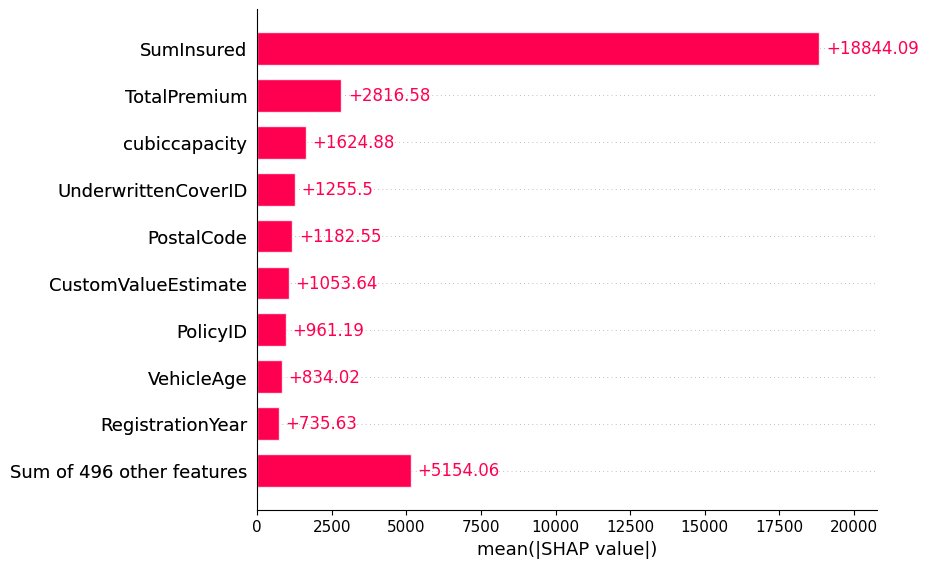

In [17]:
import shap

# Ensure columns and order match training data
X_test_num_fixed = X_test_num[X_train_num.columns].astype(float)

# SHAP needs a TreeExplainer for tree-based models
explainer = shap.Explainer(model, X_test_num_fixed)
shap_values = explainer(X_test_num_fixed, check_additivity=False)

# Summary Plot (Global Importance)
shap.plots.bar(shap_values, max_display=10)
